In [1]:
####################################
###  Fetch data and Preprocess  ###

import nltk
from nltk.corpus.reader import *
from nltk import flatten


# Read the dataset 
train = ConllCorpusReader('data/MITMovieCorpus',
                          'train.txt',
                          ['pos', 'words'])


test = ConllCorpusReader('data/MITMovieCorpus', 
                         'test.txt',
                          ['pos', 'words'])

In [2]:
##couldnt find the method to get NE so it is represented as POS
sentences = train.tagged_sents() + test.tagged_sents()
test_sentences = test.tagged_sents() 

print("Number of training records: " + str(len(train.tagged_sents())))
print("Number of testing records: " + str(len(test.tagged_sents())))
print(sentences[0])

Number of training records: 7816
Number of testing records: 1953
[('steve', 'B-Actor'), ('mcqueen', 'I-Actor'), ('provided', 'O'), ('a', 'O'), ('thrilling', 'B-Plot'), ('motorcycle', 'I-Plot'), ('chase', 'I-Plot'), ('in', 'I-Plot'), ('this', 'I-Plot'), ('greatest', 'B-Opinion'), ('of', 'I-Opinion'), ('all', 'I-Opinion'), ('ww', 'B-Plot'), ('2', 'I-Plot'), ('prison', 'I-Plot'), ('escape', 'I-Plot'), ('movies', 'I-Plot')]


In [3]:
largest_sen = max(len(sen) for sen in sentences)
print('biggest sentence has {} words'.format(largest_sen))

biggest sentence has 76 words


(array([1.600e+01, 1.140e+02, 1.740e+02, 3.122e+03, 3.341e+03, 1.313e+03,
        9.220e+02, 4.570e+02, 1.320e+02, 7.100e+01, 5.100e+01, 2.800e+01,
        1.600e+01, 5.000e+00, 1.000e+00, 2.000e+00, 1.000e+00, 1.000e+00,
        1.000e+00, 1.000e+00]),
 array([ 3.  ,  6.65, 10.3 , 13.95, 17.6 , 21.25, 24.9 , 28.55, 32.2 ,
        35.85, 39.5 , 43.15, 46.8 , 50.45, 54.1 , 57.75, 61.4 , 65.05,
        68.7 , 72.35, 76.  ]),
 <a list of 20 Patch objects>)

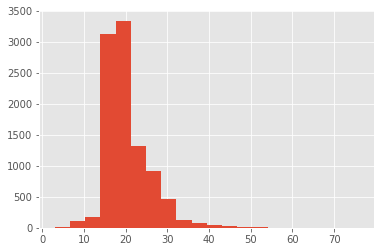

In [4]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use("ggplot")

plt.hist([len(sen) for sen in sentences], bins=20)

In [5]:
max_len = 30

X = []
padded_sent = []
x_index = 0
for s in sentences:
    for i in range(max_len):
        if i >= len(s):
            padded_sent.append("xxxPADDINGxxx")
        else:
            padded_sent.append(s[i][0])
    
    X.append(padded_sent)
    padded_sent = []
print (len(X[53]))
print(X[53])

30
['i', 'm', 'thinking', 'of', 'the', 'epic', 'movie', 'based', 'on', 'the', 'book', 'by', 'j', 'r', 'r', 'tolkien', 'featuring', 'hobbits', 'wizards', 'elves', 'and', 'a', 'dark', 'magic', 'xxxPADDINGxxx', 'xxxPADDINGxxx', 'xxxPADDINGxxx', 'xxxPADDINGxxx', 'xxxPADDINGxxx', 'xxxPADDINGxxx']


In [6]:
tags = []
for s in sentences:
    for w in s:
        tags.append(w[1])
tags = list(set(tags))
num_tags = len(tags)

print(num_tags)

25


In [7]:
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical

tags2index = {t:i for i,t in enumerate(tags)}
y = [[tags2index[w[1]] for w in s] for s in sentences]
y = pad_sequences(maxlen=max_len, sequences=y, padding="post", value=tags2index["O"])

y = [to_categorical(i, num_classes = num_tags) for i in y]

Using TensorFlow backend.


We want to change our words into numbers actually vectors to be specific (this is also also called embedding). Keras has a functional to do this but it requires us to map each unique word to a unique integer which will be passed into the function. The function takes:

__input_dim:__ The total no. of unique words in our corpus. <br>
__output_dim:__ Size of the vector that we want. <br>
__input_length:__ Size of each spicific sentence (60). 

In [8]:
words = []
for s in X:
    for w in s:
        words.append(w)
unique_words = list(set(words))
num_words = len(unique_words)

words2index = { w: i for i,w in enumerate(unique_words) }
X = [[words2index[w] for w in s] for s in X]
# X = pad_sequences(maxlen=max_len, sequences=X, padding="post", value=tags2index["xxxPADDINGxxx"])
print(X[1])

from keras.models import Model, Input
from keras.layers.merge import add
from keras.layers import LSTM, Embedding, Dense, TimeDistributed, Dropout, Bidirectional, Lambda

from sklearn.model_selection import train_test_split
X_TRAIN, X_TEST, Y_TRAIN, Y_TEST = train_test_split(X,y, test_size=0.1)


[9122, 7079, 8779, 9414, 9417, 2090, 7305, 8088, 2675, 4826, 9947, 2534, 10160, 5203, 8700, 3456, 11510, 4559, 9947, 2452, 572, 3705, 1552, 8955, 6481, 1757, 6763, 6763, 6763, 6763]


In [9]:
from keras.models import Model, Input, Sequential
from keras.layers.merge import add
from keras.layers import LSTM, Embedding, Dense, TimeDistributed, Dropout, Bidirectional, Lambda, Flatten
import numpy as np

input = Input(shape=(max_len,))
embedding = Embedding(input_dim = num_words, output_dim = 70, input_length = max_len)(input)

x = Bidirectional(LSTM(units=512, return_sequences=True,
                       recurrent_dropout=0.2, dropout=0.2))(embedding)
x_rnn = Bidirectional(LSTM(units=512, return_sequences=False,
                           recurrent_dropout=0.2, dropout=0.2))(x)
x = add([x, x_rnn])  # residual connection to the first biLSTM
out = TimeDistributed(Dense(num_tags, activation="softmax"))(x)
model = Model(input, out)
model.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"])


model.compile('adam', 'binary_crossentropy', metrics=['accuracy'])

X_TRAIN, X_TEST = np.array(X_TRAIN), np.array(X_TEST)


# print('x_train shape:', X_TRAIN.shape)
# print('x_test shape:', X_TEST.shape)
# print('out = ', out.shape)

# print()
# print()

# print(X_TRAIN)

# print()
# print()
# print()


# print(np.array(Y_TRAIN))

In [10]:
batch_size = 32

print('Training...')
model.fit(X_TRAIN, np.array(Y_TRAIN),
          validation_split=0.1,
          batch_size=batch_size,
          epochs=4)

Training...


/opt/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 7912 samples, validate on 880 samples
Epoch 1/4
7912/7912 [==============================] - 446s 56ms/step - loss: 0.0619 - accuracy: 0.9789 - val_loss: 0.0507 - val_accuracy: 0.9827
Epoch 2/4
7912/7912 [==============================] - 2014s 255ms/step - loss: 0.0398 - accuracy: 0.9872 - val_loss: 0.0365 - val_accuracy: 0.9881
Epoch 3/4
7912/7912 [==============================] - 445s 56ms/step - loss: 0.0278 - accuracy: 0.9908 - val_loss: 0.0300 - val_accuracy: 0.9899
Epoch 4/4
7912/7912 [==============================] - 451s 57ms/step - loss: 0.0226 - accuracy: 0.9923 - val_loss: 0.0280 - val_accuracy: 0.9906


In [11]:
from keras.models import model_from_json

i = 27
p = model.predict(np.array([X_TEST[i]]))
p = np.argmax(p, axis=-1)

print("{:14} ({:5}): {}".format("Word", "True", "Pred"))
for w,pred in zip(X_TEST[i],p[0]):
    print("{:14}: {}".format(unique_words[w],tags[pred]))
    
#print(len(X_TRAIN[36]))
#print(words[X_TRAIN[4][1]])

# model.save('inital.model')

# serialize model to JSON
model_json = model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights("model.h5")
print("Saved model to disk")

Word           (True ): Pred
this          : O
2011          : B-Year
romantic      : B-Genre
comedy        : I-Genre
was           : O
written       : O
by            : O
and           : O
stars         : O
kristen       : B-Actor
wiig          : I-Actor
as            : O
a             : B-Plot
woman         : I-Plot
whose         : I-Plot
life          : I-Plot
begins        : I-Plot
to            : I-Plot
unravel       : I-Plot
as            : I-Plot
her           : I-Plot
friend        : I-Plot
is            : I-Plot
preparing     : I-Plot
to            : I-Plot
get           : I-Plot
married       : I-Plot
xxxPADDINGxxx : O
xxxPADDINGxxx : O
xxxPADDINGxxx : O
Saved model to disk


In [13]:
# load json and create model
json_file = open('model.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
# load weights into new model
loaded_model.load_weights("model.h5")
print("Loaded model from disk")

Loaded model from disk


In [14]:
i = 27
p = loaded_model.predict(np.array([X_TEST[i]]))
p = np.argmax(p, axis=-1)

print("{:14} ({:5}): {}".format("Word", "True", "Pred"))
for w,pred in zip(X_TEST[i],p[0]):
    print("{:14}: {}".format(unique_words[w],tags[pred]))

Word           (True ): Pred
this          : O
2011          : B-Year
romantic      : B-Genre
comedy        : I-Genre
was           : O
written       : O
by            : O
and           : O
stars         : O
kristen       : B-Actor
wiig          : I-Actor
as            : O
a             : B-Plot
woman         : I-Plot
whose         : I-Plot
life          : I-Plot
begins        : I-Plot
to            : I-Plot
unravel       : I-Plot
as            : I-Plot
her           : I-Plot
friend        : I-Plot
is            : I-Plot
preparing     : I-Plot
to            : I-Plot
get           : I-Plot
married       : I-Plot
xxxPADDINGxxx : O
xxxPADDINGxxx : O
xxxPADDINGxxx : O


In [19]:
import json

########WRITE AS JSON
with open("dictionary.json", "w") as dict_file:
    dict_file.write( '[' );
    for i in range(num_words):
        dict_file.write(json.dumps({"word": unique_words[i], "index": words2index[unique_words[i]]}))
        
        if (i < num_words - 1):
            dict_file.write( ', ' );
    dict_file.write( ']' );
    dict_file.close()

In [26]:
with open("target.txt", "w") as target_file:
    for i in range(len(tags)):
        target_file.write( str(tags[i]) )
        if(i < len(tags) - 1):
            target_file.write( ', ' );